In [1]:
import re
import pandas as pd
from collections import OrderedDict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pymystem3 import Mystem
from string import punctuation

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
novel = "data/Толстой, Лев Николаевич - Анна Каренина.txt"

In [3]:
with open(novel, 'r') as f:
    raw_text = f.read()

In [4]:
raw_text[:5000]

'Лев Николаевич Толстой\n\nАнна Каренина\n\n                                                 Мне отмщение, и аз воздам\n\n                                ЧАСТЬ ПЕРВАЯ\n\n                                     I\n\n  Все счастливые семьи похожи друг на друга, каждая  несчастливая\nсемья несчастлива по-своему.\n  Все смешалось в доме Облонских. Жена узнала, что муж  был  в  связи  с\nбывшею в их доме француженкою-гувернанткой, и объявила мужу, что не  мо-\nжет жить с ним в одном доме. Положение это продолжалось уже третий  день\nи мучительно чувствовалось и самими супругами, и всеми членами семьи,  и\nдомочадцами. Все члены семьи и домочадцы чувствовали, что нет  смысла  в\nих сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди\nболее связаны между собой, чем они, члены семьи и  домочадцы  Облонских.\nЖена не выходила из своих комнат, мужа третий день не  было  дома.  Дети\nбегали по всему дому, как потерянные; англичанка поссорилась с экономкой\nи написала записку прияте

In [5]:
# Remove erroneous double-spaces
text = re.sub(r"(?<=[А-Яа-я,-])(\s\s)(?=[А-Яа-я,-])", " ", raw_text)

# Remove hyphens in words split by line break
text = re.sub(r"(?<=[А-Яа-я])(-\n)(?=[А-Яа-я])", "", text)

# Remove unnecessary line breaks
# text = re.sub(r"(?:[А-Яа-я])(\n)(?:[А-Яа-я\n \.])", "", raw_text)
text = re.sub(r"(?<!\n)(\n)(?!(  |\n))", " ", text)

In [6]:
(raw_text[:5000])

'Лев Николаевич Толстой\n\nАнна Каренина\n\n                                                 Мне отмщение, и аз воздам\n\n                                ЧАСТЬ ПЕРВАЯ\n\n                                     I\n\n  Все счастливые семьи похожи друг на друга, каждая  несчастливая\nсемья несчастлива по-своему.\n  Все смешалось в доме Облонских. Жена узнала, что муж  был  в  связи  с\nбывшею в их доме француженкою-гувернанткой, и объявила мужу, что не  мо-\nжет жить с ним в одном доме. Положение это продолжалось уже третий  день\nи мучительно чувствовалось и самими супругами, и всеми членами семьи,  и\nдомочадцами. Все члены семьи и домочадцы чувствовали, что нет  смысла  в\nих сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди\nболее связаны между собой, чем они, члены семьи и  домочадцы  Облонских.\nЖена не выходила из своих комнат, мужа третий день не  было  дома.  Дети\nбегали по всему дому, как потерянные; англичанка поссорилась с экономкой\nи написала записку прияте

In [7]:
print(text[:15000])

Лев Николаевич Толстой Анна Каренина

                                                 Мне отмщение, и аз воздам

                                ЧАСТЬ ПЕРВАЯ

                                     I

  Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.
  Все смешалось в доме Облонских. Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой, и объявила мужу, что не может жить с ним в одном доме. Положение это продолжалось уже третий день и мучительно чувствовалось и самими супругами, и всеми членами семьи, и домочадцами. Все члены семьи и домочадцы чувствовали, что нет смысла в их сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди более связаны между собой, чем они, члены семьи и домочадцы Облонских. Жена не выходила из своих комнат, мужа третий день не было дома.  Дети бегали по всему дому, как потерянные; англичанка поссорилась с экономкой и написала записку приятельнице, прося приискать ей новое место;

In [8]:
ak = OrderedDict()

parts = re.findall(r"(ЧАСТЬ [А-Я]+)", text)  # Split the book into the different parts

for part in parts:
    part_text = re.search(r"{}([\w\W:]*?)(ЧАСТЬ|Конец\s*\n)".format(part), text)  # Extract the content of each part
    chapters = re.findall(r"\n*\s*([IVX]+)\n*([\w\W:]*?)(?=\s{5}[IVX]+(?![a-z])|$)", part_text.group(1))  # Extract the chapter number and text for each part
    chapters = OrderedDict([(item[0], item[1].rstrip()) for item in chapters])
    ak[part] = OrderedDict(chapters)

### The format of the Anna Karenina ak dictionary is as follows:
&nbsp;   
{part 1: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'part 2': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [9]:
# Word Count
for part in ak:
    print('{:,} words in {}'.format(sum(len(ak[part][chapter].split()) for chapter in ak[part]), part))
print()    
print('{:,} total words in Анна Каренина'.format(sum(len(ak[part][chapter].split())
                                                for part in ak
                                                for chapter in ak[part])))

39,776 words in ЧАСТЬ ПЕРВАЯ
41,394 words in ЧАСТЬ ВТОРАЯ
40,486 words in ЧАСТЬ ТРЕТЬЯ
28,378 words in ЧАСТЬ ЧЕТВЕРТАЯ
39,878 words in ЧАСТЬ ПЯТАЯ
39,903 words in ЧАСТЬ ШЕСТАЯ
33,900 words in ЧАСТЬ СЕДЬМАЯ
16,356 words in ЧАСТЬ ВОСЬМАЯ

280,071 total words in Анна Каренина


In [10]:
# Average word length
for part in ak:
    text = ''
    for chapter in ak[part]:
        text = text + ak[part][chapter]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), part))

6.09 Average word length in ЧАСТЬ ПЕРВАЯ
6.12 Average word length in ЧАСТЬ ВТОРАЯ
6.18 Average word length in ЧАСТЬ ТРЕТЬЯ
6.14 Average word length in ЧАСТЬ ЧЕТВЕРТАЯ
6.15 Average word length in ЧАСТЬ ПЯТАЯ
6.14 Average word length in ЧАСТЬ ШЕСТАЯ
6.08 Average word length in ЧАСТЬ СЕДЬМАЯ
6.14 Average word length in ЧАСТЬ ВОСЬМАЯ


In [11]:
# Chapters in parts
for part in ak:
    chapters = 0
    for chapter in ak[part]:
        chapters += 1
    print('{} chapters in {}'.format(chapters, part))

34 chapters in ЧАСТЬ ПЕРВАЯ
35 chapters in ЧАСТЬ ВТОРАЯ
32 chapters in ЧАСТЬ ТРЕТЬЯ
23 chapters in ЧАСТЬ ЧЕТВЕРТАЯ
33 chapters in ЧАСТЬ ПЯТАЯ
32 chapters in ЧАСТЬ ШЕСТАЯ
31 chapters in ЧАСТЬ СЕДЬМАЯ
19 chapters in ЧАСТЬ ВОСЬМАЯ


In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
# Convert to list
data = [ak[part][chapter].replace('\n', '') for part in ak for chapter in ak[part]]
print(data[1])

  Степан Аркадьич был человек правдивый в отношении к себе самому. Он не мог обманывать себя и уверять себя, что он раскаивается в своем поступке. Он не мог теперь раскаиваться в том, что он, тридцатичетырехлетний, красивый, влюбчивый человек, не был влюблен в жену, мать пяти живых и двух умерших детей, бывшую только годом моложе его.  Он раскаивался только в том, что не умел лучше скрыть от жены. Но он чувствовал всю тяжесть своего положения и жалел жену, детей и себя. Может быть, он сумел бы лучше скрыть свои грехи от жены, если б ожидал, что это известие так на нее подействует. Ясно он никогда не обдумывал этого вопроса, но смутно ему представлялось, что жена давно догадывается, что он не верен ей, и смотрит на это сквозь пальцы. Ему даже казалось, что она, истощенная, состарившаяся, уже некрасивая женщина и ничем не замечательная, простая, только добрая мать семейства, по чувству справедливости должна быть снисходительна. Оказалось совсем противное.  "Ах, ужасно! ай, ай, ай! ужасно

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['все', 'счастливые', 'семьи', 'похожи', 'друг', 'на', 'друга', 'каждая', 'несчастливая', 'семья', 'несчастлива', 'по', 'своему', 'все', 'смешалось', 'доме', 'облонских', 'жена', 'узнала', 'что', 'муж', 'был', 'связи', 'бывшею', 'их', 'доме', 'француженкою', 'гувернанткои', 'объявила', 'мужу', 'что', 'не', 'может', 'жить', 'ним', 'одном', 'доме', 'положение', 'это', 'продолжалось', 'уже', 'третии', 'день', 'мучительно', 'чувствовалось', 'самими', 'супругами', 'всеми', 'членами', 'семьи', 'домочадцами', 'все', 'члены', 'семьи', 'домочадцы', 'чувствовали', 'что', 'нет', 'смысла', 'их', 'сожительстве', 'что', 'на', 'каждом', 'постоялом', 'дворе', 'случаино', 'сошедшиеся', 'люди', 'более', 'связаны', 'между', 'собои', 'чем', 'они', 'члены', 'семьи', 'домочадцы', 'облонских', 'жена', 'не', 'выходила', 'из', 'своих', 'комнат', 'мужа', 'третии', 'день', 'не', 'было', 'дома', 'дети', 'бегали', 'по', 'всему', 'дому', 'как', 'потерянные', 'англичанка', 'поссорилась', 'экономкои', 'написала', 'з

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['все', 'счастливые', 'семьи', 'похожи', 'друг', 'на', 'друга', 'каждая', 'несчастливая', 'семья', 'несчастлива', 'по', 'своему', 'все', 'смешалось', 'доме', 'облонских', 'жена', 'узнала', 'что', 'муж', 'был', 'связи', 'бывшею', 'их', 'доме', 'француженкою', 'гувернанткои', 'объявила', 'мужу', 'что', 'не', 'может', 'жить', 'ним', 'одном', 'доме', 'положение', 'это', 'продолжалось', 'уже', 'третии_день', 'мучительно', 'чувствовалось', 'самими', 'супругами', 'всеми', 'членами', 'семьи', 'домочадцами', 'все', 'члены', 'семьи', 'домочадцы', 'чувствовали', 'что', 'нет', 'смысла', 'их', 'сожительстве', 'что', 'на', 'каждом', 'постоялом', 'дворе', 'случаино', 'сошедшиеся', 'люди', 'более', 'связаны', 'между', 'собои', 'чем', 'они', 'члены', 'семьи', 'домочадцы', 'облонских', 'жена', 'не', 'выходила', 'из', 'своих', 'комнат', 'мужа', 'третии_день', 'не', 'было', 'дома', 'дети', 'бегали', 'по', 'всему', 'дому', 'как', 'потерянные', 'англичанка', 'поссорилась', 'экономкои', 'написала', 'записку'

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    text_out = []
    for doc in texts:
        text = " ".join(doc)
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in russian_stopwords\
                  and token != " " \
                  and token.strip() not in punctuation]
        text_out.append(tokens)
    return text_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['счастливый', 'семья', 'похожий', 'друг', 'друг', 'каждый', 'несчастливый', 'семья', 'несчастливый', 'свой', 'смешаться', 'дом', 'облонский', 'жена', 'узнавать', 'муж', 'связь', 'дом', 'француженка', 'гувернанткои', 'объявлять', 'муж', 'жить', 'дом', 'положение', 'продолжаться', 'третия', 'день', 'мучительно', 'чувствоваться', 'супруга', 'весь', 'член', 'семья', 'домочадец', 'член', 'семья', 'домочадец', 'чувствовать', 'смысл', 'сожительство', 'каждый', 'постоялый', 'двор', 'случаина', 'сходиться', 'человек', 'связанный', 'собой', 'член', 'семья', 'домочадец', 'облонский', 'жена', 'выходить', 'свой', 'комната', 'муж', 'третия', 'день', 'дома', 'ребенок', 'бегать', 'весь', 'дом', 'потерянный', 'англичанка', 'поссориться', 'экономкои', 'написать', 'записка', 'приятельница', 'просить', 'приискивать', 'еи', 'новый', 'место', 'повар', 'уходить', 'вчера', 'двор', 'время', 'обед', 'черный', 'кухарка', 'кучер', 'просить', 'расчет', 'третия', 'день', 'ссора', 'князь', 'степан', 'аркадьич', 'о

In [18]:
print(data_lemmatized[19])

['весь', 'день', 'анна', 'проводить', 'дома', 'облонский', 'принимать', 'никто', 'некоторые', 'знакомый', 'успевать', 'узнавать', 'прибытие', 'приезжать', 'день', 'анна', 'утро', 'проводить', 'долли', 'ребенок', 'посылать', 'записочка', 'брат', 'непременно', 'обедать', 'дом', 'приезжая', 'бог', 'милостивый', 'писать', 'облонский', 'обедать', 'дом', 'разговор', 'общии', 'жена', 'говорить', 'называть', 'прежде', 'отношение', 'муж', 'женоя', 'оставаться', 'отчужденность', 'речь', 'разлука', 'степан', 'аркадьич', 'видеть', 'возможность', 'объяснение', 'примирение', 'тотчас', 'обед', 'приезжать', 'кити', 'знать', 'анна', 'аркадьевна', 'очень', 'мало', 'ехать', 'сестра', 'страх', 'пред', 'принимать', 'петербургский', 'светский', 'дама', 'который', 'хвалить', 'понравиться', 'анна', 'аркадьевна', 'это', 'увидеть', 'сеичас', 'анна', 'очевидно', 'любоваться', 'красота', 'молодость', 'успевать', 'кити', 'опоминаться', 'чувствовать', 'влияние', 'чувствовать', 'влюбленный', 'способный', 'влюбляться

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 5), (9, 6), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 6), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 4), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 3), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 3), (54, 2), (55, 1), (56, 2), (57, 4), (58, 4), (59, 1), (60, 1), (61, 2), (62, 4), (63, 1), (64, 3), (65, 1), (66, 2), (67, 3), (68, 2), (69, 1), (70, 8), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 2), (87, 1), (88, 1), (89, 2), (90, 2), (91, 1), (92, 1), (93, 1), (94, 3), (95, 1), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101, 1), (102, 4), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1), (110, 2)

In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('il', 2),
  ('mio', 2),
  ('tesoro', 2),
  ('ааа', 1),
  ('алабин', 2),
  ('америка', 1),
  ('американский', 1),
  ('англичанка', 1),
  ('аркадьич', 5),
  ('ах', 6),
  ('бегать', 1),
  ('безвыходность', 1),
  ('боль', 1),
  ('бывать', 1),
  ('вернуться', 1),
  ('весело', 2),
  ('веселыи', 1),
  ('весь', 6),
  ('вечно', 1),
  ('вздрагивать', 1),
  ('видеть', 1),
  ('вина', 2),
  ('виноватый', 1),
  ('виноя', 3),
  ('висеть', 1),
  ('вместо', 1),
  ('воображение', 1),
  ('восемь', 1),
  ('воспоминание', 1),
  ('впечатление', 1),
  ('время', 1),
  ('вскакивать', 1),
  ('вспоминать', 4),
  ('вспомнить', 1),
  ('вставать', 1),
  ('вчера', 1),
  ('выбегать', 1),
  ('выражать', 1),
  ('выражение', 1),
  ('выходить', 1),
  ('выхоливать', 1),
  ('глаз', 2),
  ('глупый', 3),
  ('гнев', 1),
  ('говорить', 1),
  ('год', 1),
  ('головной', 1),
  ('горячность', 1),
  ('гостиноя', 1),
  ('графинчик', 1),
  ('грушея', 1),
  ('гувернанткои', 1),
  ('давать', 2),
  ('дармштадт', 3),
  ('двор', 2),
  

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"сказать" + 0.000*"левин" + 0.000*"который" + 0.000*"свой" + '
  '0.000*"это" + 0.000*"дело" + 0.000*"вронский" + 0.000*"александрович" + '
  '0.000*"алексей" + 0.000*"думать"'),
 (1,
  '0.000*"это" + 0.000*"сказать" + 0.000*"левин" + 0.000*"говорить" + '
  '0.000*"свой" + 0.000*"который" + 0.000*"знать" + 0.000*"вронский" + '
  '0.000*"еи" + 0.000*"видеть"'),
 (2,
  '0.073*"кити" + 0.018*"варенька" + 0.018*"княгиня" + 0.017*"князь" + '
  '0.011*"воин" + 0.009*"свой" + 0.008*"который" + 0.008*"мать" + '
  '0.008*"священник" + 0.007*"сказать"'),
 (3,
  '0.000*"сказать" + 0.000*"свой" + 0.000*"это" + 0.000*"левин" + '
  '0.000*"который" + 0.000*"мочь" + 0.000*"говорить" + 0.000*"знать" + '
  '0.000*"вронский" + 0.000*"хотеть"'),
 (4,
  '0.010*"баронесса" + 0.006*"каска" + 0.005*"петрицкий" + 0.003*"камеровския" '
  '+ 0.000*"петрицкиа" + 0.000*"вронский" + 0.000*"сказать" + 0.000*"денник" + '
  '0.000*"свой" + 0.000*"который"'),
 (5,
  '0.000*"сказать" + 0.000*"это" + 0.000

In [23]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -9.52463061453763
Coherence Score:  0.3616195470529009


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [25]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('рука', 0.020147105852254557),
   ('свой', 0.0177486408698433),
   ('глаз', 0.0167892548768788),
   ('улыбаться', 0.01598976654940838),
   ('счастие', 0.012472017908538535),
   ('улыбка', 0.012152222577550368),
   ('лицо', 0.011672529581068116),
   ('отвечать', 0.009913655260633194),
   ('белый', 0.009433962264150943),
   ('кити', 0.008954269267668692)]),
 (1,
  [('вронский', 0.07851904847075657),
   ('лошадь', 0.01681273475228045),
   ('который', 0.016455016991593633),
   ('лицо', 0.014487569307816132),
   ('видеть', 0.013056698265068861),
   ('голенищев', 0.011983544983008406),
   ('картина', 0.010373815059917725),
   ('свой', 0.010373815059917725),
   ('знать', 0.00965837953854409),
   ('фигура', 0.009121802897513862)]),
 (2,
  [('левин', 0.030959164292497624),
   ('мужик', 0.02298195631528965),
   ('старик', 0.018043684710351376),
   ('лошадь', 0.011016144349477683),
   ('который', 0.010446343779677113),
   ('дорога', 0.0100664767331434),
   ('ряд', 0.0100664767331434),
  

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


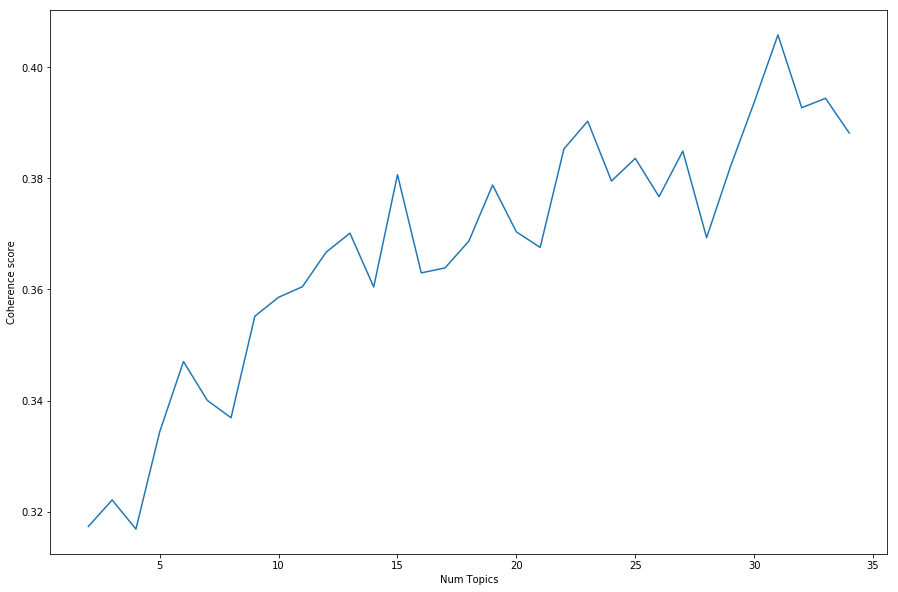

In [29]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.317339
Num Topics = 3  has Coherence Value of 0.322116
Num Topics = 4  has Coherence Value of 0.316871
Num Topics = 5  has Coherence Value of 0.334383
Num Topics = 6  has Coherence Value of 0.347024
Num Topics = 7  has Coherence Value of 0.340042
Num Topics = 8  has Coherence Value of 0.336909
Num Topics = 9  has Coherence Value of 0.35518
Num Topics = 10  has Coherence Value of 0.358594
Num Topics = 11  has Coherence Value of 0.360486
Num Topics = 12  has Coherence Value of 0.366706
Num Topics = 13  has Coherence Value of 0.370128
Num Topics = 14  has Coherence Value of 0.360445
Num Topics = 15  has Coherence Value of 0.380652
Num Topics = 16  has Coherence Value of 0.36298
Num Topics = 17  has Coherence Value of 0.363877
Num Topics = 18  has Coherence Value of 0.368685
Num Topics = 19  has Coherence Value of 0.378793
Num Topics = 20  has Coherence Value of 0.370359
Num Topics = 21  has Coherence Value of 0.367561
Num Topics = 22  has Coherence

In [31]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 16
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.047*"это" + 0.034*"знать" + 0.032*"который" + 0.029*"мочь" + 0.027*"жить" '
  '+ 0.025*"понимать" + 0.017*"душа" + 0.015*"сказать" + 0.015*"говорить" + '
  '0.015*"любить"'),
 (1,
  '0.204*"левин" + 0.028*"брат" + 0.012*"николай" + 0.012*"делать" + '
  '0.010*"становиться" + 0.010*"приезжать" + 0.010*"думать" + '
  '0.010*"константин" + 0.008*"знать" + 0.008*"хороший"'),
 (2,
  '0.115*"сказать" + 0.040*"говорить" + 0.037*"это" + 0.021*"хотеть" + '
  '0.016*"спрашивать" + 0.015*"знать" + 0.015*"улыбаться" + 0.014*"отвечать" + '
  '0.012*"очень" + 0.011*"рад"'),
 (3,
  '0.034*"это" + 0.028*"который" + 0.028*"жизнь" + 0.028*"мочь" + '
  '0.022*"чувствовать" + 0.022*"свой" + 0.020*"чувство" + 0.017*"думать" + '
  '0.013*"человек" + 0.012*"любовь"'),
 (4,
  '0.084*"алексей" + 0.076*"александрович" + 0.022*"жена" + 0.021*"дело" + '
  '0.020*"графиня" + 0.014*"лидия" + 0.014*"ивановна" + 0.012*"это" + '
  '0.012*"свой" + 0.011*"иметь"'),
 (5,
  '0.030*"дело" + 0.021*"левин" + 0.021*

In [32]:
optimal_model.show_topic(0,10)

[('это', 0.04670687004848055),
 ('знать', 0.034054629301170626),
 ('который', 0.03204446021047653),
 ('мочь', 0.028733593472862716),
 ('жить', 0.026841669622797684),
 ('понимать', 0.025304481494619842),
 ('душа', 0.01667257892869812),
 ('сказать', 0.015371881281778408),
 ('говорить', 0.015371881281778408),
 ('любить', 0.014544164597374955)]

In [33]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['это', 'знать', 'который', 'мочь', 'жить', 'понимать', 'душа', 'сказать', 'говорить', 'любить']
Topic 1: ['левин', 'брат', 'николай', 'делать', 'становиться', 'приезжать', 'думать', 'константин', 'знать', 'хороший']
Topic 2: ['сказать', 'говорить', 'это', 'хотеть', 'спрашивать', 'знать', 'улыбаться', 'отвечать', 'очень', 'рад']
Topic 3: ['это', 'который', 'жизнь', 'мочь', 'чувствовать', 'свой', 'чувство', 'думать', 'человек', 'любовь']
Topic 4: ['алексей', 'александрович', 'жена', 'дело', 'графиня', 'лидия', 'ивановна', 'это', 'свой', 'иметь']
Topic 5: ['дело', 'левин', 'это', 'свияжския', 'свияжский', 'хозяиство', 'понимать', 'наш', 'помещик', 'свой']
Topic 6: ['нога', 'идти', 'васенька', 'спать', 'ласка', 'весловския', 'болото', 'подниматься', 'голос', 'звук']
Topic 7: ['анна', 'долли', 'александровна', 'дарья', 'еи', 'ребенок', 'который', 'понимать', 'это', 'нея']
Topic 8: ['который', 'очень', 'свой', 'видеть', 'время', 'иметь', 'отношение', 'новый', 'совершенно', 'вместе'

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2128,"это, который, жизнь, мочь, чувствовать, свой, ...","Все счастливые семьи похожи друг на друга, к..."
1,1,11.0,0.2089,"степан, аркадьич, это, сказать, облонский, дел...",Степан Аркадьич был человек правдивый в отно...
2,2,11.0,0.1638,"степан, аркадьич, это, сказать, облонский, дел...","Одевшись, Степан Аркадьич прыснул на себя ду..."
3,3,15.0,0.2406,"рука, говорить, лицо, сказать, глаз, это, докт...","Дарья Александровна, в кофточке и с пришпиле..."
4,4,11.0,0.2678,"степан, аркадьич, это, сказать, облонский, дел...",Степан Аркадьич в школе учился хорошо благодар...
5,5,12.0,0.2628,"кити, княгиня, еи, варенька, мать, князь, знат...","Когда Облонский спросил у Левина, зачем он, ..."
6,6,16.0,0.4130,"сергей, иванович, сказать, который, брат, свой...","Приехав с утренним поездом в Москву, Левин о..."
7,7,1.0,0.2196,"левин, брат, николай, делать, становиться, при...","Когда профессор уехал, Сергей Иванович обрат..."
8,8,6.0,0.1731,"нога, идти, васенька, спать, ласка, весловския...","В четыре часа, чувствуя свое бьющееся сердце..."
9,9,11.0,0.2607,"степан, аркадьич, это, сказать, облонский, дел...","Когда Левин вошел с Облонским в гостиницу, о..."


In [35]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7,7,1.0,0.2196,"левин, брат, николай, делать, становиться, при...","Когда профессор уехал, Сергей Иванович обрат..."
23,23,1.0,0.2014,"левин, брат, николай, делать, становиться, при...","""Да, что-то есть во мне противное, отталкива..."
24,24,1.0,0.2295,"левин, брат, николай, делать, становиться, при...","- Так видишь, - продолжал Николай Левин, с у..."
100,100,1.0,0.1937,"левин, брат, николай, делать, становиться, при...","Левин уже давно сделал замечание, что когда ..."
114,114,1.0,0.2022,"левин, брат, николай, делать, становиться, при...","Когда Кити уехала и Левин остался один, он п..."
124,124,1.0,0.2652,"левин, брат, николай, делать, становиться, при...","Княгиня Щербацкая находила, что сделать свад..."
129,129,1.0,0.2542,"левин, брат, николай, делать, становиться, при...","Когда обряд обручения окончился, церковнослу..."
142,142,1.0,0.1662,"левин, брат, николай, делать, становиться, при...","""Скрыл от премудрых и открыл детям и неразум..."
149,149,0.0,0.4061,"это, знать, который, мочь, жить, понимать, душ...","- Ну что, Капитоныч? - сказал Сережа, румяны..."
150,150,0.0,0.4725,"это, знать, который, мочь, жить, понимать, душ...",После учителя был урок отца. Пока отец не пр...


In [36]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['это,',
  'который,',
  'жизнь,',
  'мочь,',
  'чувствовать,',
  'свой,',
  'чувство,',
  'думать,',
  'человек,',
  'любовь'],
 ['степан,',
  'аркадьич,',
  'это,',
  'сказать,',
  'облонский,',
  'дело,',
  'очень,',
  'тысяча,',
  'место,',
  'знать'],
 ['степан,',
  'аркадьич,',
  'это,',
  'сказать,',
  'облонский,',
  'дело,',
  'очень,',
  'тысяча,',
  'место,',
  'знать'],
 ['рука,',
  'говорить,',
  'лицо,',
  'сказать,',
  'глаз,',
  'это,',
  'доктор,',
  'видеть,',
  'минута,',
  'выражение'],
 ['степан,',
  'аркадьич,',
  'это,',
  'сказать,',
  'облонский,',
  'дело,',
  'очень,',
  'тысяча,',
  'место,',
  'знать'],
 ['кити,',
  'княгиня,',
  'еи,',
  'варенька,',
  'мать,',
  'князь,',
  'знать,',
  'говорить,',
  'дочь,',
  'свой'],
 ['сергей,',
  'иванович,',
  'сказать,',
  'который,',
  'брат,',
  'свой,',
  'разговор,',
  'народ,',
  'человек,',
  'говорить'],
 ['левин,',
  'брат,',
  'николай,',
  'делать,',
  'становиться,',
  'приезжать,',
  'думать,',
  'конс

In [37]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['это', 'который', 'жизнь', 'мочь', 'чувствовать']
1. Dominant keywords: ['степан', 'аркадьич', 'это', 'сказать', 'облонский']
2. Dominant keywords: ['степан', 'аркадьич', 'это', 'сказать', 'облонский']
3. Dominant keywords: ['рука', 'говорить', 'лицо', 'сказать', 'глаз']
4. Dominant keywords: ['степан', 'аркадьич', 'это', 'сказать', 'облонский']
5. Dominant keywords: ['кити', 'княгиня', 'еи', 'варенька', 'мать']
6. Dominant keywords: ['сергей', 'иванович', 'сказать', 'который', 'брат']
7. Dominant keywords: ['левин', 'брат', 'николай', 'делать', 'становиться']
8. Dominant keywords: ['нога', 'идти', 'васенька', 'спать', 'ласка']
9. Dominant keywords: ['степан', 'аркадьич', 'это', 'сказать', 'облонский']
10. Dominant keywords: ['степан', 'аркадьич', 'это', 'сказать', 'облонский']
11. Dominant keywords: ['кити', 'княгиня', 'еи', 'варенька', 'мать']
12. Dominant keywords: ['это', 'который', 'жизнь', 'мочь', 'чувствовать']
13. Dominant keywords: ['сказать', 'говорить'

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4921,"это, знать, который, мочь, жить, понимать, душ...","Левин шел большими шагами по большой дороге,..."
1,1.0,0.2652,"левин, брат, николай, делать, становиться, при...","Княгиня Щербацкая находила, что сделать свад..."
2,2.0,0.3773,"сказать, говорить, это, хотеть, спрашивать, зн...","Княгиня Бетси, не дождавшись конца последнег..."
3,3.0,0.3134,"это, который, жизнь, мочь, чувствовать, свой, ...",Левин был женат третий месяц. Он был счастли...
4,4.0,0.4634,"алексей, александрович, жена, дело, графиня, л...",Приемная комната знаменитого петербургского ...
5,5.0,0.4594,"дело, левин, это, свияжския, свияжский, хозяис...","- Только если бы не жалко бросить, что завед..."
6,6.0,0.5369,"нога, идти, васенька, спать, ласка, весловския...","Васенька так шибко гнал лошадей, что они при..."
7,7.0,0.4165,"анна, долли, александровна, дарья, еи, ребенок...","Оставшись одна, Дарья Александровна взглядом..."
8,8.0,0.2854,"который, очень, свой, видеть, время, иметь, от...",Анна в этот первый период своего освобождени...
9,9.0,0.4204,"сказать, еи, анна, муж, мочь, хотеть, нея, сын...",Хотя Анна упорно и с озлоблением противоречи...


In [39]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: это, знать, который, мочь, жить, понимать, душа, сказать, говорить, любить

  Левин шел большими шагами по большой дороге, прислушиваясь не столько к своим мыслям (он не мог еще разобрать их), сколько к душевному состоянию, прежде никогда им не испытанному.  Слова, сказанные мужиком, произвели в его душе действие электрической искры, вдруг преобразившей и сплотившей в одно целый рой разрозненных, бессильных отдельных мыслей, никогда не перестававших занимать его. Мысли эти незаметно для него самого занимали его и в то время, когда он говорил об отдаче земли.  Он чувствовал в своей душе что-то новое и с наслаждением ощупывал это новое, не зная еще, что это такое.  "Не для нужд своих жить, а для бога. Для какого бога? Для бога. И что можно сказать бессмысленнее того, что он сказал? Он сказал, что не надо жить для своих нужд, то есть что не надо жить для того, что мы понимаем, к чему нас влечет, чего нам хочется, а надо жить для чего-то непонятного, для бога, кото

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"это, знать, который, мочь, жить, понимать, душ...",8,0.0335
1,1.0,"левин, брат, николай, делать, становиться, при...",8,0.0335
2,2.0,"сказать, говорить, это, хотеть, спрашивать, зн...",24,0.1004
3,3.0,"это, который, жизнь, мочь, чувствовать, свой, ...",13,0.0544
4,4.0,"алексей, александрович, жена, дело, графиня, л...",19,0.0795
5,5.0,"дело, левин, это, свияжския, свияжский, хозяис...",12,0.0502
6,6.0,"нога, идти, васенька, спать, ласка, весловския...",9,0.0377
7,7.0,"анна, долли, александровна, дарья, еи, ребенок...",17,0.0711
8,8.0,"который, очень, свой, видеть, время, иметь, от...",7,0.0293
9,9.0,"сказать, еи, анна, муж, мочь, хотеть, нея, сын...",23,0.0962


In [41]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"это, знать, который, мочь, жить, понимать, душа, сказать, говорить, любить",8,0.0335
1,1.0,"левин, брат, николай, делать, становиться, приезжать, думать, константин, знать, хороший",8,0.0335
2,2.0,"сказать, говорить, это, хотеть, спрашивать, знать, улыбаться, отвечать, очень, рад",24,0.1004
3,3.0,"это, который, жизнь, мочь, чувствовать, свой, чувство, думать, человек, любовь",13,0.0544
4,4.0,"алексей, александрович, жена, дело, графиня, лидия, ивановна, это, свой, иметь",19,0.0795
5,5.0,"дело, левин, это, свияжския, свияжский, хозяиство, понимать, наш, помещик, свой",12,0.0502
6,6.0,"нога, идти, васенька, спать, ласка, весловския, болото, подниматься, голос, звук",9,0.0377
7,7.0,"анна, долли, александровна, дарья, еи, ребенок, который, понимать, это, нея",17,0.0711
8,8.0,"который, очень, свой, видеть, время, иметь, отношение, новый, совершенно, вместе",7,0.0293
9,9.0,"сказать, еи, анна, муж, мочь, хотеть, нея, сын, знать, положение",23,0.0962


In [42]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)

# LDA using individual sentences as documents

In [43]:
from nltk import tokenize

In [44]:
# Convert to list
print('Creating corpus')
data = []
for part in ak:
    for chapter in ak[part]:
        data.extend(tokenize.sent_tokenize(ak[part][chapter].replace('\n', '')))

# Tokenize into words
print('Tokenizing')
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
print('Creating bigrams and trigrams')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
print('Building bigram and trigram models')
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
print('Removing stopwords')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Forming bigrams')
data_words_bigrams = make_bigrams(data_words_nostops)

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Do lemmatization keeping only noun, adj, vb, adv
print('Lemmatizing')
data_lemmatized = lemmatization(data_words_bigrams)

# Create Dictionary
print('Creating dictionary')
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
print('Creating corpus')
texts = data_lemmatized

# Term Document Frequency
print('Creating term frequency list')
corpus = [id2word.doc2bow(text) for text in texts]

Creating corpus
Tokenizing
Creating bigrams and trigrams
Building bigram and trigram models
Removing stopwords
Forming bigrams
Lemmatizing
Creating dictionary
Creating corpus
Creating term frequency list


In [45]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=18, id2word=id2word)

In [46]:
# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


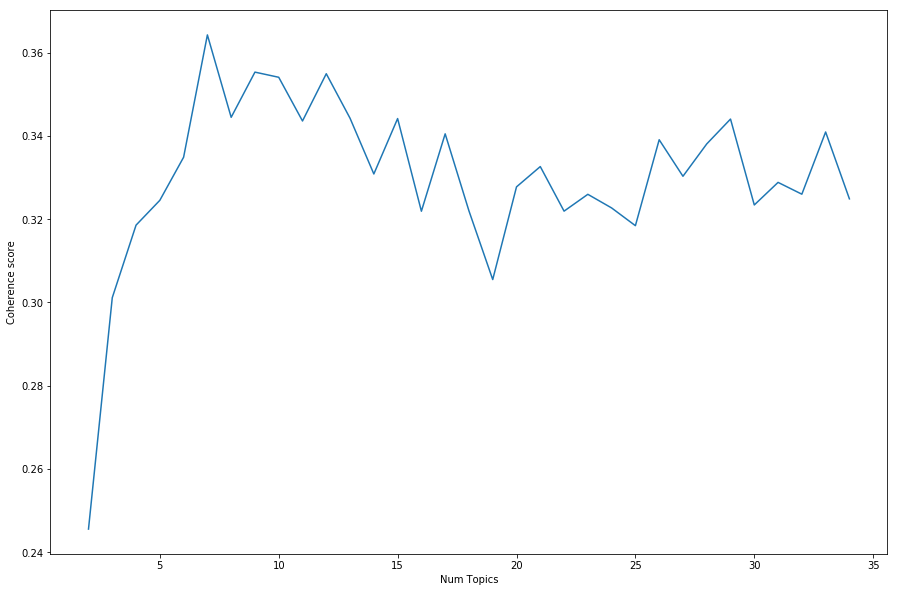

In [47]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.245518
Num Topics = 3  has Coherence Value of 0.301119
Num Topics = 4  has Coherence Value of 0.318548
Num Topics = 5  has Coherence Value of 0.324513
Num Topics = 6  has Coherence Value of 0.334864
Num Topics = 7  has Coherence Value of 0.364253
Num Topics = 8  has Coherence Value of 0.344453
Num Topics = 9  has Coherence Value of 0.355312
Num Topics = 10  has Coherence Value of 0.354073
Num Topics = 11  has Coherence Value of 0.343573
Num Topics = 12  has Coherence Value of 0.354923
Num Topics = 13  has Coherence Value of 0.344225
Num Topics = 14  has Coherence Value of 0.330841
Num Topics = 15  has Coherence Value of 0.344154
Num Topics = 16  has Coherence Value of 0.321891
Num Topics = 17  has Coherence Value of 0.340483
Num Topics = 18  has Coherence Value of 0.321971
Num Topics = 19  has Coherence Value of 0.305472
Num Topics = 20  has Coherence Value of 0.327741
Num Topics = 21  has Coherence Value of 0.332618
Num Topics = 22  has Coheren

In [49]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 8
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

Perplexity:  -9.1288220855563
Coherence Score:  0.3248422227570943


In [51]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['левин', 'очень', 'становиться', 'время', 'разговор', 'вопрос', 'идти', 'дом', 'первый', 'оставаться']
Topic 1: ['сказать', 'анна', 'кити', 'еи', 'отвечать', 'слово', 'долли', 'смотреть', 'голос', 'замечать']
Topic 2: ['который', 'дело', 'жизнь', 'самый', 'иметь', 'весь', 'новый', 'хороший', 'прежде', 'положение']
Topic 3: ['говорить', 'вронский', 'хотеть', 'думать', 'сказать', 'сделать', 'жена', 'муж', 'это', 'княгиня']
Topic 4: ['свой', 'чувствовать', 'левин', 'мысль', 'минута', 'давать', 'жить', 'продолжать', 'вместе', 'особенно']
Topic 5: ['входить', 'выходить', 'пойти', 'стоять', 'дверь', 'садиться', 'комната', 'стол', 'проходить', 'лошадь']
Topic 6: ['рука', 'алексей', 'лицо', 'александрович', 'глаз', 'улыбаться', 'взять', 'голова', 'выражение', 'пред']
Topic 7: ['это', 'знать', 'мочь', 'понимать', 'человек', 'видеть', 'делать', 'брат', 'сергей', 'иванович']
Topic 8: ['степан', 'аркадьич', 'спрашивать', 'приезжать', 'день', 'александровна', 'дарья', 'поехать', 'старый',

In [52]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [53]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"это, знать, который, мочь, жить, понимать, душа, сказать, говорить, любить",2724.0,0.1347
1,1.0,"левин, брат, николай, делать, становиться, приезжать, думать, константин, знать, хороший",2340.0,0.1157
2,2.0,"сказать, говорить, это, хотеть, спрашивать, знать, улыбаться, отвечать, очень, рад",1877.0,0.0928
3,3.0,"это, который, жизнь, мочь, чувствовать, свой, чувство, думать, человек, любовь",2291.0,0.1133
4,4.0,"алексей, александрович, жена, дело, графиня, лидия, ивановна, это, свой, иметь",1639.0,0.0810
5,5.0,"дело, левин, это, свияжския, свияжский, хозяиство, понимать, наш, помещик, свой",2058.0,0.1018
6,6.0,"нога, идти, васенька, спать, ласка, весловския, болото, подниматься, голос, звук",1910.0,0.0944
7,7.0,"анна, долли, александровна, дарья, еи, ребенок, который, понимать, это, нея",1932.0,0.0955
8,8.0,"который, очень, свой, видеть, время, иметь, отношение, новый, совершенно, вместе",1870.0,0.0925
9,9.0,"сказать, еи, анна, муж, мочь, хотеть, нея, сын, знать, положение",1583.0,0.0783
